<a href="https://colab.research.google.com/github/AliaksandrSiarohin/motion-cosegmentation/blob/master/part_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part-swap demo for paper "Motion Supervised co-part Segmentation"

**Clone repository**

In [0]:
!git clone https://github.com/AliaksandrSiarohin/motion-cosegmentation motion-co-seg

Cloning into 'motion-co-seg'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 10355 (delta 19), reused 8 (delta 3), pack-reused 10320
Receiving objects: 100% (10355/10355), 252.08 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (1682/1682), done.


In [0]:
cd motion-co-seg/

/content/motion-co-seg


**Mount your Google drive folder on Colab**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Add shortcut of https://drive.google.com/open?id=1SsBifjoM_qO0iFzb8wLlsz_4qW2j8dZe to your google drive.**


**Load target video and source image**

In [0]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/16.png')
target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/04.mp4')

#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

def display(source, target, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(target)):
        cols = [source]
        cols.append(target[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, target_video).to_html5_video())

**Loading checkpoints with 10 parts**

In [0]:
from part_swap import load_checkpoints

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-10segments.yaml', 
                                               checkpoint='/content/gdrive/My Drive/motion-supervised-co-segmentation/vox-10segments.pth.tar',
                                               blend_scale=1)

**Visualizing the segmentation**

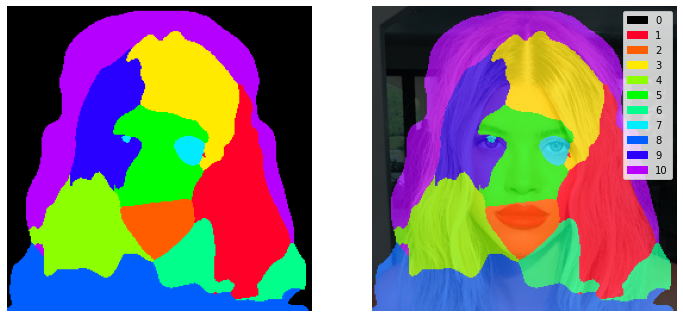

In [0]:
import torch
import torch.nn.functional as F

import matplotlib.patches as mpatches

def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        inp = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda()
        if supervised:
            inp = F.interpolate(inp, size=(512, 512))
            inp = (inp - network.mean) / network.std
            mask = torch.softmax(network(inp)[0], dim=1)
            mask = F.interpolate(mask, size=image.shape[:2])
        else:
            mask = network(inp)['segmentation']
            mask = F.interpolate(mask, size=image.shape[:2], mode='bilinear')
    
    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float()
    
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy()
    color_mask = 0
    patches = []
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i+1)] * color.reshape(1, 1, 3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))

    ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')

visualize_segmentation(source_image, segmentation_module, hard=True)
plt.show()

**Identify index of the part that you want to swap. For example to make trump with red lips part 2 should be used**

In [0]:
from part_swap import make_video

predictions = make_video(swap_index=[2], source_image = source_image, target_video = target_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
HTML(display(source_image, target_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:07<00:00, 27.87it/s]


In [0]:
# Saving result video
from skimage import img_as_ubyte
imageio.mimsave('../result.mp4', [img_as_ubyte(frame) for frame in predictions], fps=30)

**Changing eye color**

In [0]:
source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/26.png')
target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/11.mp4')
source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

predictions = make_video(swap_index=[7,9], source_image = source_image, target_video = target_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
HTML(display(source_image, target_video, predictions).to_html5_video())

100%|██████████| 109/109 [00:04<00:00, 26.92it/s]


In [0]:
del predictions
del source_image
del target_video
del reconstruction_module
del segmentation_module

**Examples with 5-segments model**

In [0]:
from part_swap import load_checkpoints

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-5segments.yaml', 
                                               checkpoint='/content/gdrive/My Drive/motion-supervised-co-segmentation/vox-5segments.pth.tar',
                                               blend_scale=1)

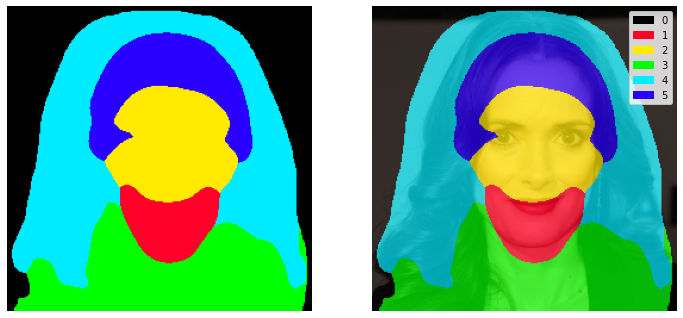

In [0]:
source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/27.png')
source_image = resize(source_image, (256, 256))[..., :3]
visualize_segmentation(source_image, segmentation_module, hard=True)
plt.show()

**Changing hair**

In [0]:
from part_swap import make_video

source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/27.png')
target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/02.mp4')
source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

predictions = make_video(swap_index=[3, 4, 5], source_image = source_image, target_video = target_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
HTML(display(source_image, target_video, predictions).to_html5_video())

100%|██████████| 128/128 [00:04<00:00, 27.28it/s]


**Source segmentation can be used if warped source region will be outside target mask**

In [0]:
from part_swap import make_video

source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/27.png')
target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/04.mp4')
source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

predictions = make_video(swap_index=[3, 4,5], source_image = source_image, target_video = target_video, use_source_segmentation=True,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
HTML(display(source_image, target_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:07<00:00, 27.36it/s]


**Adding Beard**

In [0]:
source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/23.png')
target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/07.mp4')
source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

predictions = make_video(swap_index=[1], source_image = source_image, target_video = target_video,
                             segmentation_module=segmentation_module, reconstruction_module=reconstruction_module)
HTML(display(source_image, target_video, predictions).to_html5_video())

100%|██████████| 128/128 [00:04<00:00, 26.99it/s]


In [0]:
del predictions
del source_image
del target_video
del reconstruction_module
del segmentation_module

**For the reference we provide a method for supervised part-swaps**

**Download model of @zllrunning for face parsing**

In [0]:
!git clone https://github.com/AliaksandrSiarohin/face-makeup.PyTorch face_parsing

Cloning into 'face_parsing'...
remote: Enumerating objects: 62, done.
remote: Total 62 (delta 0), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (62/62), done.


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


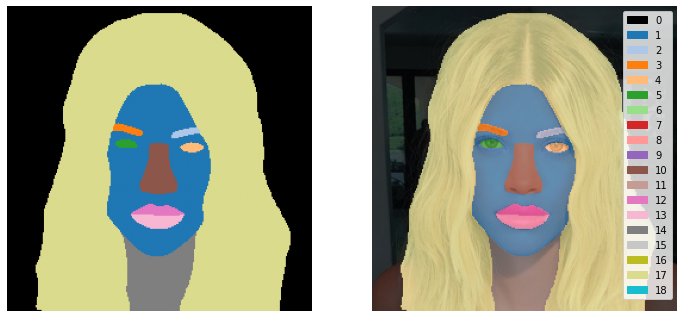

In [0]:
from part_swap import load_face_parser
face_parser = load_face_parser(cpu=False)

source_image = imageio.imread('/content/gdrive/My Drive/motion-supervised-co-segmentation/16.png')
target_video = imageio.mimread('/content/gdrive/My Drive/motion-supervised-co-segmentation/04.mp4')

#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]
target_video = [resize(frame, (256, 256))[..., :3] for frame in target_video]

visualize_segmentation(source_image, face_parser, supervised=True, hard=True, colormap='tab20')
plt.show()

In [0]:
from part_swap import load_checkpoints

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-10segments.yaml', 
                                               checkpoint='/content/gdrive/My Drive/motion-supervised-co-segmentation/vox-first-order.pth.tar',
                                               blend_scale=0.125, first_order_motion_model=True)


Segmentation part initialized at random.


In [0]:
predictions = make_video(swap_index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], source_image = source_image,
                         target_video = target_video, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)
HTML(display(source_image, target_video, predictions).to_html5_video())

100%|██████████| 211/211 [00:12<00:00, 16.97it/s]
